In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
import nltk.data

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
import os
import numpy as np

dir = '/content/drive/MyDrive/NLP'
sentences = []
for file in os.listdir(dir):
    if file.endswith(".txt"):
        filename = os.path.join(dir, file)
        fp = open(filename, encoding="latin-1")
        data = fp.read()
        tokens = tokenizer.tokenize(data)
        sentences.extend(tokens)
        break

len(sentences)

191

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
entities = [get_entities(i) for i in tqdm(sentences)]
entities[10:20]

100%|██████████| 2004/2004 [00:22<00:00, 88.34it/s]


[["'s", 'beer'],
 ['man', 'curtain'],
 ['', ''],
 ['', 'doorway'],
 ['', ''],
 ['', ''],
 ['two  two', 'pads'],
 ['She', 'beer man'],
 ['girl', 'hills'],
 ['country', 'sun']]

In [ ]:
relations = [get_relation(i) for i in tqdm(sentences)]
pd.Series(relations).value_counts()[:20]

100%|██████████| 8704/8704 [01:54<00:00, 76.00it/s]


was      636
said     331
is       309
had      132
were     112
know      82
are       76
be        75
's        65
have      63
been      61
asked     54
made      50
came      47
went      43
cried     41
got       41
think     41
heard     39
put       38
dtype: int64

In [ ]:
# extract subject
source = [i[0] for i in entities]

# extract object
target = [i[1] for i in entities]

#kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, fla

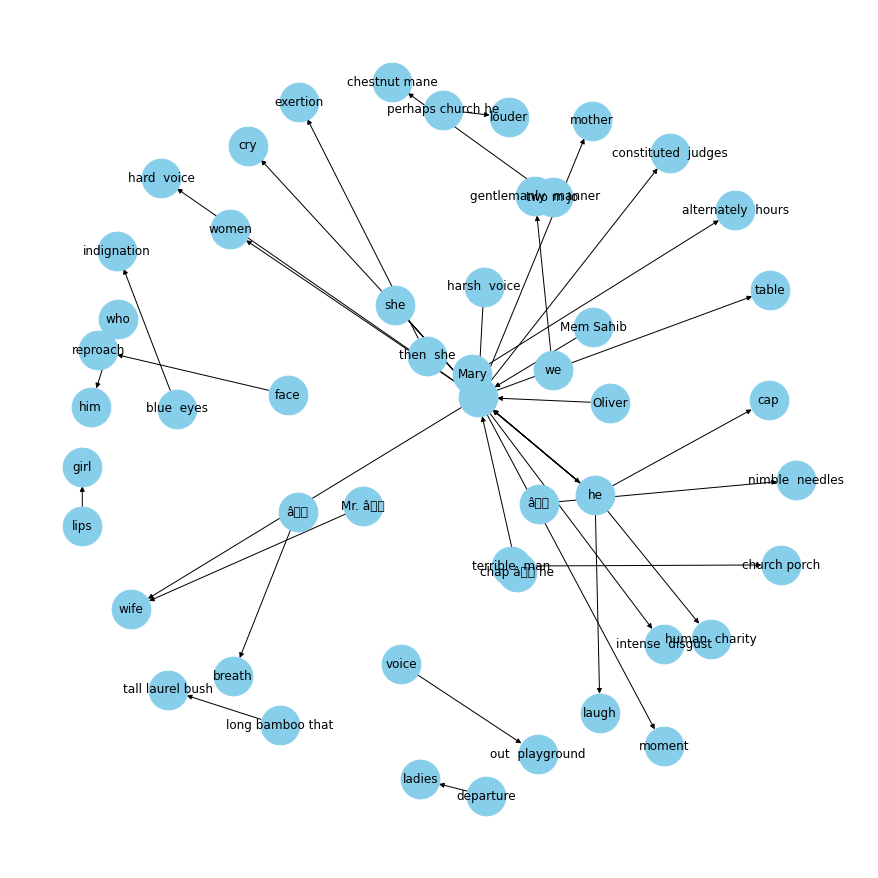

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="cried"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
#!pip install neuralcoref
import spacy
import neuralcoref

# Load SpaCy
nlp = spacy.load('en')
# Add neural coref to SpaCy's pipe
neuralcoref.add_to_pipe(nlp)

def coref_resolution(text):
    """Function that executes coreference resolution on a given text"""
    doc = nlp(text)
    # fetches tokens with whitespaces from spacy document
    tok_list = list(token.text_with_ws for token in doc)
    for cluster in doc._.coref_clusters:
        # get tokens from representative cluster name
        cluster_main_words = set(cluster.main.text.split(' '))
        for coref in cluster:
            if coref != cluster.main:  # if coreference element is not the representative element of that cluster
                if coref.text != cluster.main.text and bool(set(coref.text.split(' ')).intersection(cluster_main_words)) == False:
                    # if coreference element text and representative element text are not equal and none of the coreference element words are in representative element. This was done to handle nested coreference scenarios
                    tok_list[coref.start] = cluster.main.text + \
                        doc[coref.end-1].whitespace_
                    for i in range(coref.start+1, coref.end):
                        tok_list[i] = ""

    return "".join(tok_list)

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.morphology.Morphology size changed, may indicate binary incompatibility. Expected 104 from C header, got 112 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.vocab.Vocab size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: spacy.tokens.span.Span size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject
  return f(*args, **kwds)


In [ ]:
import urllib
from string import punctuation
import nltk
import json
import itertools

ENTITY_TYPES = ["human", "person", "company", "enterprise", "business", "geographic region",
                "human settlement", "geographic entity", "territorial entity type", "organization"]

def wikifier(text, lang="en", threshold=0.8):
    """Function that fetches entity linking results from wikifier.com API"""
    # Prepare the URL.
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "tgbdmkpmkluegqfbawcwjywieevmza"),
        ("pageRankSqThreshold", "%g" %
         threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "100"), ("nWordsToIgnoreFromList", "100"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3")
    ])
    url = "http://www.wikifier.org/annotate-article"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout=60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output the annotations.
    results = list()
    for annotation in response["annotations"]:
        # Filter out desired entity classes
        if ('wikiDataClasses' in annotation) and (any([el['enLabel'] in ENTITY_TYPES for el in annotation['wikiDataClasses']])):

            # Specify entity label
            if any([el['enLabel'] in ["human", "person"] for el in annotation['wikiDataClasses']]):
                label = 'Person'
            elif any([el['enLabel'] in ["company", "enterprise", "business", "organization"] for el in annotation['wikiDataClasses']]):
                label = 'Organization'
            elif any([el['enLabel'] in ["geographic region", "human settlement", "geographic entity", "territorial entity type"] for el in annotation['wikiDataClasses']]):
                label = 'Location'
            else:
                label = None

            results.append({'title': annotation['title'], 'wikiId': annotation['wikiDataItemId'], 'label': label,
                            'characters': [(el['chFrom'], el['chTo']) for el in annotation['support']]})
    return results

## OpenNRE

In [ ]:
!git clone https://github.com/thunlp/OpenNRE.git

Cloning into 'OpenNRE'...
remote: Enumerating objects: 1518, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1518 (delta 82), reused 105 (delta 71), pack-reused 1377
Receiving objects: 100% (1518/1518), 266.83 MiB | 27.98 MiB/s, done.
Resolving deltas: 100% (903/903), done.


In [ ]:
%cd OpenNRE
!pip install -r requirements.txt

/content/OpenNRE
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 1.3 MB 36.1 MB/s 
     |████████████████████████████████| 234 kB 38.0 MB/s 
     |████████████████████████████████| 7.0 MB 39.3 MB/s 
     |████████████████████████████████| 1.5 MB 40.3 MB/s 
     |████████████████████████████████| 2.9 MB 41.0 MB/s 
     |████████████████████████████████| 895 kB 45.9 MB/s 
     |████████████████████████████████| 1.2 MB 25.8 MB/s 
     |████████████████████████████████| 749 kB 41.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: pluggy
    Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstal

In [ ]:
%cd OpenNRE
import opennre


model = opennre.get_model('wiki80_bert_softmax')
#model = model.cuda()

/content/OpenNRE


2022-04-25 18:23:11,399 - root - INFO - Loading BERT pre-trained checkpoint.


In [ ]:
for sentence in sentences:
  tokens = nltk.word_tokenize(sentence)
  tagged = nltk.pos_tag(tokens)
  entities = nltk.chunk.ne_chunk(tagged)
  relations_list = []
  # Iterate over every permutation pair of entities
  for permutation in itertools.permutations(entities, 2):
    if permutation[0] == [] or permutation[1] == []:
      continue
    # Relationship extraction with OpenNRE
    data = model.infer(
        {'text': sentence, 'h': {'pos': [source[0], source[1] + 1]}, 't': {'pos': [target[0], target[1] + 1]}})
    if data[1] > 0.8:
        relations_list.append(
              {'source': p['title'], 'target': t['title'], 'type': data[0]})

NameError: ignored

In [ ]:
# First get all the entities in the sentence
sentence = sentences[200]
entities = [ wikifier(i) for i in tqdm(sentences)]
#entities = wikifier(sentence)


100%|██████████| 2004/2004 [33:37<00:00,  1.01s/it]


TypeError: ignored

In [ ]:
#!pip install pytextspan
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
import itertools
import textspan

x = 0
relations_list = []
for sentence in sentences:
  tokens = nltk.word_tokenize(sentence)
  spans = textspan.get_original_spans(tokens, sentence)
  t_spans = dict()
  for i in range(len(tokens)):
    if spans[i] == []:
      continue
    t_spans[tokens[i]] = spans[i][0]
  tagged = nltk.pos_tag(list(t_spans.keys()))
  #entities = nltk.chunk.ne_chunk(tagged)
  pattern = 'NP: {<DT>?<JJ>*<NN>}'
  cp = nltk.RegexpParser(pattern)
  cs = cp.parse(tagged)
  entities = tree2conlltags(cs)
  for entity in itertools.permutations(entities, 2):
    src = t_spans[entity[0][0]]
    trg = t_spans[entity[1][0]]
    data = model.infer({'text': sentence, 'h': {'pos': [src[0], src[1]]}, 't': {'pos': [trg[0], trg[1]]}})
    if data[1] > 0.85:
      relations_list.append({'source': entity[0][0], 'target': entity[1][0], 'type': data[0]})
  print(x)
  x += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190


In [ ]:
relations_list

[{'source': 'ERNEST', 'target': '(', 'type': 'characters'},
 {'source': 'ERNEST', 'target': '1899-4961', 'type': 'characters'},
 {'source': 'ERNEST', 'target': ')', 'type': 'characters'},
 {'source': 'ERNEST', 'target': 'HILLS', 'type': 'characters'},
 {'source': 'ERNEST', 'target': 'LIKE', 'type': 'characters'},
 {'source': 'ERNEST', 'target': 'WHITE', 'type': 'characters'},
 {'source': 'ERNEST', 'target': 'ELEPHANTS', 'type': 'characters'},
 {'source': 'ERNEST', 'target': 'hills', 'type': 'characters'},
 {'source': 'ERNEST', 'target': 'long', 'type': 'characters'},
 {'source': 'ERNEST', 'target': 'white', 'type': 'characters'},
 {'source': 'ERNEST', 'target': '.', 'type': 'characters'},
 {'source': 'HEMINGWAY', 'target': 'ERNEST', 'type': 'characters'},
 {'source': 'HEMINGWAY', 'target': '(', 'type': 'characters'},
 {'source': 'HEMINGWAY', 'target': '1899-4961', 'type': 'characters'},
 {'source': 'HEMINGWAY', 'target': ')', 'type': 'characters'},
 {'source': 'HEMINGWAY', 'target': 'L

In [ ]:
relations_list = []
# Iterate over every permutation pair of entities
for permutation in itertools.permutations(entities, 2):
  if permutation[0] == [] or permutation[1] == []:
    continue
  print(permutation)
  for p in permutation[0]:
    for source in p['characters']:
      for t in permutation[1]:
        for target in t['characters']:
            # Relationship extraction with OpenNRE
            data = model.infer(
                {'text': sentence, 'h': {'pos': [source[0], source[1] + 1]}, 't': {'pos': [target[0], target[1] + 1]}})
            if data[1] > 0.8:
                relations_list.append(
                      {'source': p['title'], 'target': t['title'], 'type': data[0]})

Streaming output truncated to the last 5000 lines.
([{'title': 'Earth', 'wikiId': 'Q2', 'label': 'Location', 'characters': [(21, 25)]}], [{'title': 'Dante Alighieri', 'wikiId': 'Q1067', 'label': 'Person', 'characters': [(26, 30)]}])
([{'title': 'Earth', 'wikiId': 'Q2', 'label': 'Location', 'characters': [(21, 25)]}], [{'title': 'Rhine', 'wikiId': 'Q584', 'label': 'Location', 'characters': [(58, 62)]}, {'title': 'Principality of Leiningen', 'wikiId': 'Q541181', 'label': 'Organization', 'characters': [(71, 79)]}])
([{'title': 'Earth', 'wikiId': 'Q2', 'label': 'Location', 'characters': [(21, 25)]}], [{'title': 'Western world', 'wikiId': 'Q160381', 'label': 'Location', 'characters': [(68, 75), (72, 75)]}])
([{'title': 'Earth', 'wikiId': 'Q2', 'label': 'Location', 'characters': [(21, 25)]}], [{'title': 'British Army', 'wikiId': 'Q222595', 'label': 'Organization', 'characters': [(12, 17)]}])
([{'title': 'Earth', 'wikiId': 'Q2', 'label': 'Location', 'characters': [(21, 25)]}], [{'title': 'Pri

In [ ]:
import pandas

dataframe = pandas.DataFrame.from_records(relations_list)

In [ ]:
dataframe[dataframe['type'] == 'mother']

,source,target,type


In [ ]:
dataframe.to_pickle("/content/drive/MyDrive/NLP/model/pandas_dataframe.pkl")